In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


from functions.parse_data import synth_dataloader
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os
import random

/tmp/ipykernel_152249/3292627016.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-21 13:15:38.642116: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 13:15:38.676650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 13:1

In [2]:
#Load data
df=synth_dataloader('SMHIdata',drop_cols=True)
df.head()

#Set columns for X and y (input/output features)
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
          'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']
y_cols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
          'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

#Find X and y
X=df[X_cols]
y=df[y_cols]

#Separate testdata from rest for 80/10/10 Train/Val/Test split
X_trainval, X_test, y_trainval, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

#Add noise to X_test, 0 mean with stdev equal to 3% of mean of each feature
np.random.seed(313)
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X.to_numpy(),axis=0)*0.03

In [3]:
#Load models
base_path = 'pytorch_models/Angles_as_input-with/'
model_paths = ['model0/model_file','model1/model_file','model2/model_file','model3/model_file','model4/model_file']
models = [torch.load(base_path+model_paths[i]) for i in range(len(model_paths))]

#Manually set quantiles
quantiles = np.array([0.1,0.5,0.9])
est = np.where(quantiles==0.5)[0].item()

#Make preds
preds_total=[]
#Make predictions and evaluate
for i,model in enumerate(models):
    preds = model.predict(X_test.to_numpy())
    #Keep track of ensemble prediction
    if i==0:
        preds_total=preds
    else:
        preds_total=preds_total+preds

#Now find ensemble predictions
preds_total=preds_total/len(model_paths)


AttributeError: 'QuantileNetworkMM' object has no attribute 'tX_mean'

In [ ]:
#Load and show error metrics (trainval/test data is split the same way)
err_mets = pd.read_csv(base_path+'model_metrics.csv')
err_mets

,Ensemble_mean,Ensemble_index,MSE,PSNR,R2_score,Mean_Quantile_Loss
0,False,0.0,0.006872,21.657572,0.844371,0.434540
1,False,1.0,0.006931,21.620956,0.842170,0.439213
2,False,2.0,0.006800,21.703696,0.845398,0.437210
3,False,3.0,0.006879,21.653264,0.844443,0.437215
4,False,4.0,0.006830,21.684270,0.845131,0.436347
5,True,NaN,0.006451,21.932715,0.853711,0.418341


In [ ]:
#Find COTs of all test points
testindices=y_test.index
COTs=np.array(df['COT'].iloc[testindices])

#Divide into bins depending on COT
clear_true = y_test.to_numpy()[(COTs==0),:]
clear_pred = preds_total[(COTs==0),:,:]
thin_true = y_test.to_numpy()[(COTs>0) &  (COTs<3.6),:]
thin_pred = preds_total[(COTs>0) & (COTs<3.6),:,:]
semi_true = y_test.to_numpy()[(COTs>=3.6) & (COTs<23),:]
semi_pred = preds_total[(COTs>=3.6) & (COTs<23),:,:]
thick_true = y_test.to_numpy()[(COTs>=23),:]
thick_pred = preds_total[(COTs>=23),:,:]


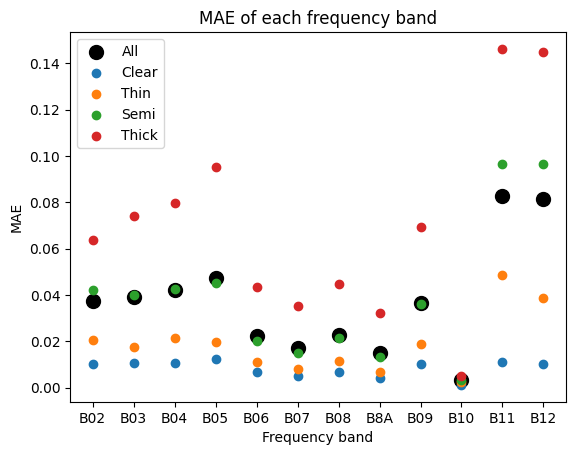

In [ ]:
#Find and print MAE of each band
MAE_col_tot = np.mean(np.abs(y_test.to_numpy()-preds_total[:,:,est]),axis=0)
MAE_col_clear = np.mean(np.abs(clear_true-clear_pred[:,:,est]),axis=0)
MAE_col_thin = np.mean(np.abs(thin_true-thin_pred[:,:,est]),axis=0)
MAE_col_semi = np.mean(np.abs(semi_true-semi_pred[:,:,est]),axis=0)
MAE_col_thick = np.mean(np.abs(thick_true-thick_pred[:,:,est]),axis=0)

x=np.arange(np.size(MAE_col_tot))
plt.figure()
plt.scatter(x,MAE_col_tot,c='black',s=100)
plt.scatter(x,MAE_col_clear)
plt.scatter(x,MAE_col_thin)
plt.scatter(x,MAE_col_semi)
plt.scatter(x,MAE_col_thick)
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.title('MAE of each frequency band')
plt.xlabel('Frequency band')
plt.ylabel('MAE')
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

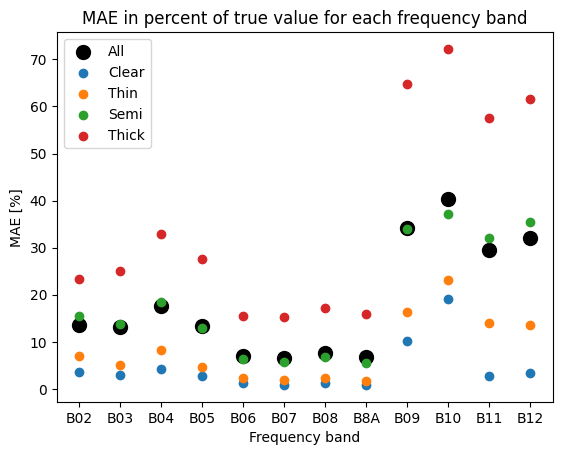

In [ ]:
error_percent_tot = np.mean(100*np.divide(np.abs(y_test.to_numpy()-preds_total[:,:,est]),y_test.to_numpy()),axis=0)
error_percent_clear = np.mean(100*np.divide(np.abs(clear_true-clear_pred[:,:,est]),clear_true),axis=0)
error_percent_thin = np.mean(100*np.divide(np.abs(thin_true-thin_pred[:,:,est]),thin_true),axis=0)
error_percent_semi = np.mean(100*np.divide(np.abs(semi_true-semi_pred[:,:,est]),semi_true),axis=0)
error_percent_thick = np.mean(100*np.divide(np.abs(thick_true-thick_pred[:,:,est]),thick_true),axis=0)


plt.figure()
plt.scatter(x,error_percent_tot,c='black',s=100)
plt.scatter(x,error_percent_clear)
plt.scatter(x,error_percent_thin)
plt.scatter(x,error_percent_semi)
plt.scatter(x,error_percent_thick)
plt.title('MAE in percent of true value for each frequency band')
plt.ylabel('MAE [%]')
plt.xlabel('Frequency band')
plt.xticks(x, ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12'])
plt.legend(['All','Clear','Thin','Semi','Thick'])
plt.show()

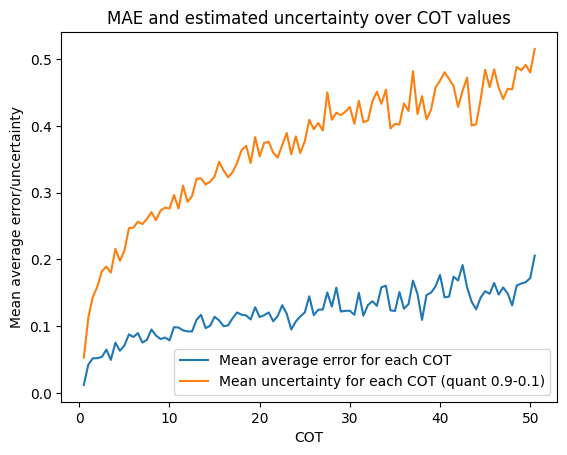

In [ ]:
#find sorted numpy indices and sort COT array
COTidx=np.argsort(COTs)
COT_sorted = COTs[COTidx]

#sort numpy test and preds by COT
y_test_np_sort=y_test.to_numpy()[COTidx,:]
y_pred_sort=preds_total[COTidx,:,:]

#Find errors and uncs for chosen bands
all_bands=False
if all_bands:
    errors = np.mean(np.abs(y_test_np_sort[:,:]-y_pred_sort[:,:,est]),axis=1)
    uncs = np.mean(y_pred_sort[:,:,-1]-y_pred_sort[:,:,0],axis=1)
else:
    band = 10
    errors = np.abs(y_test_np_sort[:,band]-y_pred_sort[:,band,est])
    uncs = y_pred_sort[:,band,-1]-y_pred_sort[:,band,0]

#sort errors and uncs into bins based on COT
COTedges=np.linspace(0,50.5,102)
err_bins = np.zeros(len(COTedges)-1)
unc_bins = np.zeros(len(COTedges)-1)
bin_freq = np.zeros(len(COTedges)-1)

for i in range(len(COT_sorted)):
    for j in range(len(COTedges)-1):   
        if COT_sorted[i] >= COTedges[j] and COT_sorted[i] < COTedges[j+1]:
            err_bins[j] = err_bins[j] + errors[i]
            unc_bins[j] = unc_bins[j] + uncs[i]
            bin_freq[j] = bin_freq[j] + 1
            break

#Find mean errs and uncs in each bin
err_mean_bins = err_bins/bin_freq
unc_mean_bins = unc_bins/bin_freq

x_COT=COTedges[:-1]+0.5
plt.figure()
plt.plot(x_COT,err_mean_bins)
plt.plot(x_COT,unc_mean_bins)
plt.title('MAE and estimated uncertainty over COT values')
plt.legend(['Mean average error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean average error/uncertainty')
plt.show()



In [ ]:
plt.figure()
plt.scatter(err_mean_bins,unc_mean_bins,c=x_COT)
plt.title('MAE and estimated uncertainty over COT values')
#plt.legend(['Mean average error for each COT','Mean uncertainty for each COT (quant 0.9-0.1)'])
plt.xlabel('COT')
plt.ylabel('Mean average error/uncertainty')
plt.show()